# Imports

In [19]:
import sys
path = '/home/servot82/PILOT'
if path not in sys.path:
    sys.path.append(path)
    
import time
import pathlib
import warnings
warnings.filterwarnings('ignore')
    
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from tqdm.notebook import tqdm
from statsmodels.regression.linear_model import OLS
from pilot.Pilot import PILOT
from sklearn.tree import DecisionTreeRegressor

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation functions

In [2]:
def generate_data(n_sample, n_feature) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = []
    y = np.random.randn(n_sample)
    cat_feat = []
    for feature in range(n_feature):
        if np.random.choice(['cat', 'num'], p=[0.1, 0.9]) == 'cat':
            x = np.random.choice([0, 1, 2], size=n_sample)
            if np.random.choice(['p_conc', 'nothing']) == 'p_conc':
                y = y + np.where(x == 0, 1, np.where(x == 1, -1, 0))
            cat_feat.append(feature)
        else:
            kind = np.random.choice(['pcon', 'plin', 'blin', 'lin', 'nothing'])
            x = np.random.randn(n_sample) * np.random.randint(1, 10) + np.random.randint(1, 10)
            split = np.random.choice(x)
            if kind == 'pcon':
                y = y + np.where(x < split, 1, -1)
            elif kind == 'lin':
                y = y + 0.1 + x * 0.1
            elif kind == 'plin':
                y = y + np.where(x < split, 0.1 - 0.1 * x, 0.1 + 0.1 * x)
            elif kind == 'blin':
                crossing_y = 0.1 - 0.1 * split
                second_intercept = crossing_y - 0.1 * split
                y = y + np.where(x < split, 0.1 - 0.1 * x, second_intercept + 0.1 * x)
        X.append(x)
        
    return np.array(X).T, y, np.array(cat_feat, dtype=np.int64)

# Experiment

In [ ]:
n_samples = np.logspace(1, 4, num=20, dtype=np.int64)
n_features = np.logspace(0, 2.8, num=20, dtype=np.int64) + 1

results = []
for n_sample in tqdm(n_samples):
    for n_feature in tqdm(n_features):
        for random_seed in range(5):
            np.random.seed(random_seed)
            X, y, cat_feat = generate_data(n_sample, n_feature)
            pilot = PILOT(max_depth=10, min_sample_split=2, min_sample_leaf=1, truncation_factor=1, rel_tolerance=0.01, min_unique_values_regression=2)
            start = time.time()
            pilot.fit(X, y, cat_feat)
            end = time.time()
            results.append(dict(n_samples=n_sample, n_features=n_feature, time_elapsed=end - start, **pilot.model_tree.nodes_selected()))
pd.DataFrame(results).to_csv('/home/servot82/PILOT/Output/pilot_computation_time_simulation.csv', index=False)

In [20]:
n_samples = np.logspace(1, 4, num=20, dtype=np.int64)
n_features = np.logspace(0, 2.8, num=20, dtype=np.int64) + 1

results = []
for n_sample in tqdm(n_samples):
    for n_feature in tqdm(n_features):
        for random_seed in range(5):
            np.random.seed(random_seed)
            X, y, cat_feat = generate_data(n_sample, n_feature)
            tree = DecisionTreeRegressor(max_depth=10, min_samples_split=2, min_samples_leaf=1)
            start = time.time()
            tree.fit(X, y)
            end = time.time()
            results.append(dict(n_samples=n_sample, n_features=n_feature, time_elapsed=end - start))
pd.DataFrame(results).to_csv('/home/servot82/PILOT/Output/decision_tree_computation_time_simulation.csv', index=False)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

# Analysis

In [9]:
results = pd.read_csv('/home/servot82/PILOT/Output/pilot_computation_time_simulation.csv')

results = results.assign(
    log_t=np.log(results['time_elapsed']),
    log_n=np.log(results['n_samples']),
    log_p=np.log(results['n_features']),
    log__nlog_n=np.log(np.log(results['n_samples'])*results['n_samples']),
    log__plog_p=np.log(np.log(results['n_features'])*results['n_features']),
)

In [21]:
results = pd.read_csv('/home/servot82/PILOT/Output/decision_tree_computation_time_simulation.csv')

results = results.assign(
    log_t=np.log(results['time_elapsed']),
    log_n=np.log(results['n_samples']),
    log_p=np.log(results['n_features']),
    log__nlog_n=np.log(np.log(results['n_samples'])*results['n_samples']),
    log__plog_p=np.log(np.log(results['n_features'])*results['n_features']),
)

## Log t ~ Log n +  Log p

<bound method Axes.axline of <AxesSubplot: xlabel='log_n', ylabel='log_t'>>

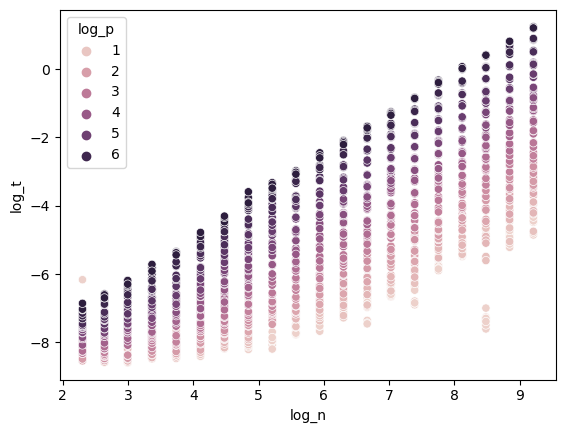

In [22]:
ax = sns.scatterplot(results, x='log_n', y='log_t', hue='log_p')
ax.axline

In [23]:
m = OLS(endog=results['log_t'], exog=sm.add_constant(results[['log_n', 'log_p']])).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_t   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 1.286e+04
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        09:13:34   Log-Likelihood:                -1945.9
No. Observations:                2000   AIC:                             3898.
Df Residuals:                    1997   BIC:                             3915.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.8362      0.049   -263.157      0.0

## Log t ~ n Log n + Log p

In [24]:
m = OLS(endog=results['log_t'], exog=sm.add_constant(results[['log__nlog_n', 'log_p']])).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_t   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 1.196e+04
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        09:13:38   Log-Likelihood:                -2012.6
No. Observations:                2000   AIC:                             4031.
Df Residuals:                    1997   BIC:                             4048.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -13.2394      0.053   -248.957      

## Log t ~ Log n +  p Log p

In [25]:
m = OLS(endog=results['log_t'], exog=sm.add_constant(results[['log_n', 'log__plog_p']])).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_t   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 1.144e+04
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        09:13:42   Log-Likelihood:                -2054.0
No. Observations:                2000   AIC:                             4114.
Df Residuals:                    1997   BIC:                             4131.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -12.6566      0.051   -250.007      

## Log t ~ n Log n +  p Log p

In [26]:
m = OLS(endog=results['log_t'], exog=sm.add_constant(results[['log__nlog_n', 'log__plog_p']])).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_t   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 1.071e+04
Date:                Mon, 31 Jul 2023   Prob (F-statistic):               0.00
Time:                        09:13:44   Log-Likelihood:                -2114.1
No. Observations:                2000   AIC:                             4234.
Df Residuals:                    1997   BIC:                             4251.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -13.0597      0.055   -236.996      

## Pilot vs CART

In [27]:
results_pilot = pd.read_csv('/home/servot82/PILOT/Output/pilot_computation_time_simulation.csv')
results_cart = pd.read_csv('/home/servot82/PILOT/Output/decision_tree_computation_time_simulation.csv')

In [35]:
results_pilot.groupby(['n_samples', 'n_features'])['time_elapsed'].mean().rename('pilot').to_frame().join(
    results_cart.groupby(['n_samples', 'n_features'])['time_elapsed'].mean().rename('cart')
    ).assign(ratio=lambda x: x['pilot'] / x['cart']).sample(5)

,,pilot,cart,ratio
n_samples,n_features,,,
61,450,4.025927,0.006035,667.118245
127,450,12.911554,0.016737,771.449479
1623,59,6.987675,0.038411,181.919510
20,321,0.415357,0.001094,379.699011
10,4,0.002616,0.000209,12.490665
